# Parameter scan for the GAN data set

In [55]:
import sys
import numpy as np
import optuna
import pickle
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import gmean
from collections import Counter


In [41]:
studies = []
for i in range(11):
    try:
        studies.append(pickle.load(open(f"../data/paramscan/paramscan_gan2d_may_{i}.pickle", "rb")))
    except FileNotFoundError as e:
        print(f"Param scan run {i} is missing")       
                       
trials = [study.trials_dataframe() for study in studies]


Param scan run 9 is missing


In [46]:
for i, trial in enumerate(trials):
    trial.index = [f"job_{i}_trial_{j}" for j in trial["number"]]

results = pd.concat(trials)
results = results.drop(["number", "state", "params_batchsize"], axis=1)
results = results.sort_values(by="value", ascending=True)


In [47]:
results

,value,datetime_start,datetime_complete,params_actnorm,params_batchnorm,params_clip,params_dropout,params_innerlayers,params_linchannelfactor,params_lineartransform,params_linlayers,params_msefactor,params_outerlayers,params_splinebins,params_splinerange,params_uvl2reg,params_weightdecay
job_0_trial_0,1.284325e+01,2020-05-06 13:40:50.908694,2020-05-06 15:54:12.115269,True,False,8.664731,0.0,4,1,lu,2,2.826056,24,9,8.0,2.207574e-03,1.657426e-08
job_6_trial_4,1.297267e+01,2020-05-06 18:03:22.150609,2020-05-06 20:21:03.670227,True,False,1.150883,0.2,5,1,svd,1,0.246734,24,4,8.0,2.043687e-05,6.127100e-02
job_1_trial_3,1.321264e+01,2020-05-06 17:46:58.991418,2020-05-06 19:37:32.262241,True,False,1.326237,0.0,4,1,svd,2,0.544589,20,3,6.0,8.107946e-03,1.035982e-02
job_7_trial_2,1.321634e+01,2020-05-06 16:18:49.794783,2020-05-06 19:04:28.612964,True,False,3.599224,0.2,9,2,permutation,1,0.297883,24,4,8.0,6.594732e-08,1.624687e-03
job_0_trial_3,1.359748e+01,2020-05-06 17:46:41.243271,2020-05-06 20:21:54.900393,True,False,46.524689,0.0,7,2,permutation,3,2.726240,16,11,6.0,3.764686e-02,3.204271e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
job_2_trial_5,1.000000e+09,2020-05-06 23:13:27.619152,2020-05-06 23:13:34.537135,True,True,6.634901,0.0,7,1,lu,1,0.028586,24,17,8.0,1.033005e-06,4.754388e-09
job_2_trial_7,1.000000e+09,2020-05-07 00:42:38.429933,2020-05-07 00:42:45.986144,False,True,33.716699,0.2,4,1,lu,2,0.005597,20,20,8.0,9.063747e-04,1.073160e-02
job_7_trial_5,1.000000e+09,2020-05-06 20:42:16.775061,2020-05-06 20:42:25.881555,True,False,1.745987,0.2,10,2,lu,3,0.154422,16,20,10.0,3.217962e-09,4.893061e-04
job_3_trial_1,1.000000e+09,2020-05-06 15:02:05.893670,2020-05-06 15:04:25.314988,True,False,78.171389,0.2,6,2,lu,3,1.010508,16,13,10.0,1.011425e-03,1.231977e-03


In [48]:
results.columns

Index(['value', 'datetime_start', 'datetime_complete', 'params_actnorm',
       'params_batchnorm', 'params_clip', 'params_dropout',
       'params_innerlayers', 'params_linchannelfactor',
       'params_lineartransform', 'params_linlayers', 'params_msefactor',
       'params_outerlayers', 'params_splinebins', 'params_splinerange',
       'params_uvl2reg', 'params_weightdecay'],
      dtype='object')

In [62]:
edge_dict = {
    "actnorm": [-0.5, 0.5, 1.5],
    "batchnorm": [-0.5, 0.5, 1.5],
    "batchsize": [0, 100],
    "dropout": [-0.5, 0.1, 1.5],
    "innerlayers": np.linspace(2.5, 10.5, 9),
    "outerlayers": np.linspace(2., 26., 7),
    "linchannelfactor": [0.5, 1.5, 2.5],
    "linlayers": [0.5, 1.5, 2.5, 3.5],
    "lineartransform": None,
    "splinerange": [5., 7., 9., 11.],
    #"splinebins": np.linespace()
}

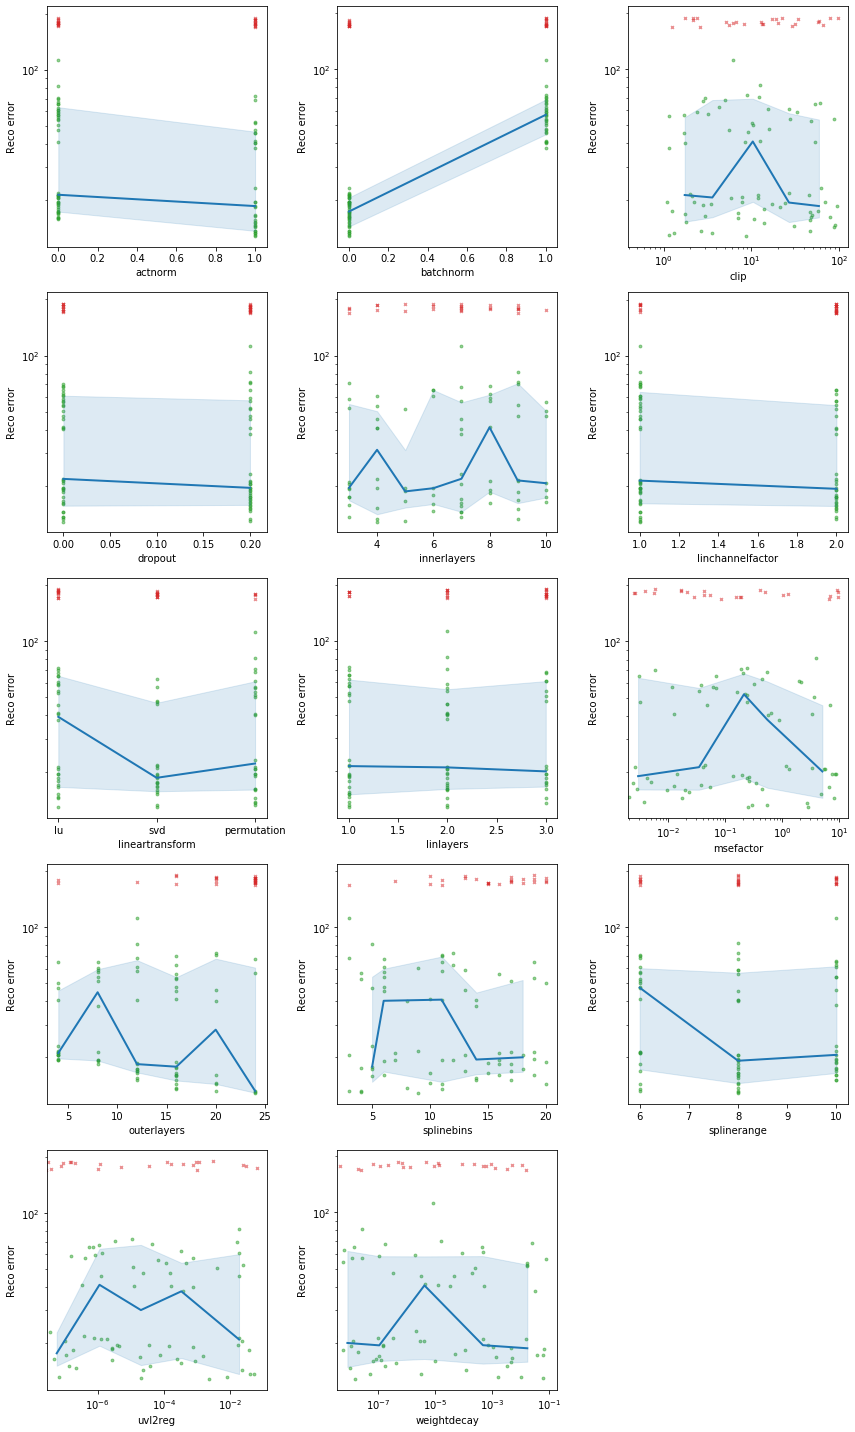

In [71]:
params = [c.replace("params_", "") for c in results.columns if "params_" in c]
n = len(params)
ncols = 3
nrows = (n - 1) // ncols + 1

y_err = 1.


plt.figure(figsize=(ncols * 4, nrows * 4))

for i, param in enumerate(params):
    ax = plt.subplot(nrows, ncols, i+1)
    
    x, y = results[f"params_{param}"], results["value"]
    filter_ = y < 0.99e9
    x_ = x[filter_]
    y_ = y[filter_]
    y_err_min = 1.5 * np.max(y_)
    y_err_max = 1.7 * np.max(y_)
    
    if param in edge_dict:
        edges = edge_dict[param]
    else:
        edges = np.percentile(x_, np.linspace(0., 100., 6))
        
    if edges is None:  # Non-numeric x axes
        counter = Counter(x)
        x_dict = {label: val for val, label in enumerate(counter.keys())}
        x = np.array([x_dict[this_x] for this_x in x])
        x_ = x[filter_]
        edges = np.linspace(-0.5, len(counter.keys()) - 0.5, len(counter.keys()) + 1)
        plt.xticks((edges[1:] + edges[:-1])/2, list(counter.keys()))
        
    plt.scatter(x_, y_, marker= "o", s=8., c="C2", alpha=0.5)
    plt.scatter(x[~filter_], np.random.uniform(y_err_min, y_err_max, size=len(x[~filter_])), marker="x", s=8., c="C3", alpha=0.5)

    x_means = [np.median(x_[(x_ > min_)&(x_ < max_)]) for min_, max_ in zip(edges[:-1], edges[1:])]
    y_means = [np.median(y_[(x_ > min_)&(x_ < max_)]) for min_, max_ in zip(edges[:-1], edges[1:])]
    y_low = [np.percentile(y_[(x_ > min_)&(x_ < max_)], 16) for min_, max_ in zip(edges[:-1], edges[1:])]
    y_high = [np.percentile(y_[(x_ > min_)&(x_ < max_)], 84) for min_, max_ in zip(edges[:-1], edges[1:])]

    plt.fill_between(x_means, y_low, y_high, color="C0", alpha=0.15)
    plt.plot(x_means, y_means, c="C0", lw=2.0)
    
    plt.xlabel(param)
    plt.ylabel("Reco error")
    
    plt.yscale("log")
    # plt.ylim(y_.min()/1.1, y_err*1.1)
    if param in ["clip", "msefactor", "weightdecay", "uvl2reg"]:
        plt.xscale("log")
        # plt.xlim(0.5 * x_.min(), 2.*x_.max())
    
plt.tight_layout()
plt.savefig("../figures/gan2d_paramscan.pdf")
